# 05. 어택 명확도 기반 타격 레이어링 (Onset Clarity)

이벤트별 **Attack Time (10% → 90% 도달 시간)**을 측정하여 타격의 또렷함(Clarity)을 수치화합니다.

In [8]:
import sys
import os
import shutil
import json

# 프로젝트 루트를 경로에 추가
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.insert(0, project_root)

import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# 한글 폰트 설정 (macOS 기본 폰트 사용)
plt.rcParams['font.family'] = ['AppleGothic', 'Apple SD Gothic Neo', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

print(f"프로젝트 루트: {project_root}")
print(f"Librosa 버전: {librosa.__version__}")

프로젝트 루트: /Users/laxogud/MADCAMP/W4/music-anaylzer
Librosa 버전: 0.11.0


In [9]:
# 입력 오디오 경로 (01_energy와 동일)
# audio_path = os.path.join(project_root, 'audio_engine', 'samples', 'sample_drum_basic_60.mp3')
audio_path = os.path.join(project_root, 'audio_engine', 'samples', 'stems', 'htdemucs', 'sample_ropes_short', 'drums.wav')

if os.path.exists(audio_path):
    y, sr = librosa.load(audio_path)
    duration = len(y) / sr
    print(f"파일: {os.path.basename(audio_path)}")
    print(f"샘플링 레이트: {sr} Hz, 길이: {duration:.2f} 초")
else:
    raise FileNotFoundError(f"파일을 찾을 수 없습니다: {audio_path}")

파일: drums.wav
샘플링 레이트: 22050 Hz, 길이: 31.11 초


In [10]:
# Onset 검출 (01_energy와 파라미터 동일하게 유지)
hop_length = 256
onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
onset_frames = librosa.onset.onset_detect(
    onset_envelope=onset_env, sr=sr, hop_length=hop_length,
    delta=0.07, wait=4, backtrack=False,
)
onset_times = librosa.frames_to_time(onset_frames, sr=sr, hop_length=hop_length)
strengths = onset_env[onset_frames]

# BPM 추정
tempo, _ = librosa.beat.beat_track(y=y, sr=sr, hop_length=hop_length)
bpm = float(tempo) if hasattr(tempo, "item") else float(tempo)

print(f"검출된 타격점 수: {len(onset_times)}")
print(f"추정 BPM: {bpm:.1f}")

검출된 타격점 수: 126
추정 BPM: 89.1


/var/folders/6c/v395vbb952ggdz819m67vbg80000gn/T/ipykernel_77818/4247418297.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  bpm = float(tempo) if hasattr(tempo, "item") else float(tempo)


## 2) Onset Clarity (어택 명확도) 측정

* **측정 방식**: Amplitude Envelope에서 10% → 90% 도달 시간(Attack Time) 측정.
* **Clarity Score**: `peak_salience * (1 / attack_time)` 형태 (정규화 포함).
* 윈도우: onset 전후 일정 구간을 분석하여 어택 구간 추출.

In [11]:
def get_attack_time(y_segment, sr, plot=False):
    """
    주어진 오디오 세그먼트에서 10% -> 90% attack time을 계산합니다.
    """
    # Amplitude envelope (absolute value)
    env = np.abs(y_segment)
    
    # Peak amplitude
    peak_idx = np.argmax(env)
    peak_val = env[peak_idx]
    
    if peak_val < 1e-7:
        return 0.0, 0.0, 0.0
    
    # Peak 이전 구간만 분석 (어택 구간)
    pre_peak_env = env[:peak_idx+1]
    
    if len(pre_peak_env) < 2:
        return 0.0, 0.0, 0.0
    
    # 10%, 90% 임계값
    t10_val = 0.1 * peak_val
    t90_val = 0.9 * peak_val
    
    # 시점 찾기 (보간법 사용)
    x = np.arange(len(pre_peak_env))
    try:
        # 10% 시점: 처음으로 10%를 넘는 지점 근처
        idx10 = np.where(pre_peak_env >= t10_val)[0][0]
        if idx10 > 0:
            # 선형 보간
            v0, v1 = pre_peak_env[idx10-1], pre_peak_env[idx10]
            t10 = (idx10 - 1) + (t10_val - v0) / (v1 - v0 + 1e-10)
        else:
            t10 = 0.0
            
        # 90% 시점: 처음으로 90%를 넘는 지점 근처
        idx90 = np.where(pre_peak_env >= t90_val)[0][0]
        if idx90 > 0:
            v0, v1 = pre_peak_env[idx90-1], pre_peak_env[idx90]
            t90 = (idx90 - 1) + (t90_val - v0) / (v1 - v0 + 1e-10)
        else:
            t90 = 0.0
            
        attack_samples = t90 - t10
        attack_time_ms = (attack_samples / sr) * 1000
        
        return attack_time_ms, t10, t90
    except:
        return 0.0, 0.0, 0.0

# 이웃 onset 기반 가변 윈도우 (겹침 방지): pre_sec = min(50ms, 0.45*gap_prev), post_sec = min(20ms, 0.45*gap_next)
deltas = np.diff(onset_times)
gap_prev = np.concatenate([[np.inf], deltas])
gap_next = np.concatenate([deltas, [np.inf]])

attack_times = []
for i in range(len(onset_times)):
    pre_sec = min(0.05, 0.45 * gap_prev[i])
    post_sec = min(0.02, 0.45 * gap_next[i])
    start_sample = max(0, int(round((onset_times[i] - pre_sec) * sr)))
    end_sample = min(len(y), int(round((onset_times[i] + post_sec) * sr)))
    
    y_seg = y[start_sample:end_sample]
    a_time, _, _ = get_attack_time(y_seg, sr)
    attack_times.append(a_time)

attack_times = np.array(attack_times)
print(f"Attack Time 범위: {attack_times.min():.2f} ms ~ {attack_times.max():.2f} ms")
print(f"평균 Attack Time: {np.mean(attack_times):.2f} ms")

Attack Time 범위: 0.00 ms ~ 69.76 ms
평균 Attack Time: 29.65 ms


In [12]:
def robust_norm(x):
    """01_energy와 동일한 robust 정규화"""
    p1, p99 = np.percentile(x, [1, 99])
    if p99 == p1:
        return np.zeros_like(x)
    x_norm = (x - p1) / (p99 - p1)
    return np.clip(x_norm, 0, 1)

# Clarity = Strength * (1 / AttackTime)
# AttackTime이 0인 경우 방지
safe_attack = np.clip(attack_times, 0.1, None)
clarity_raw = strengths * (1.0 / safe_attack)

clarity_score = robust_norm(clarity_raw)

print(f"Clarity Score 범위: {clarity_score.min():.4f} ~ {clarity_score.max():.4f}")

Clarity Score 범위: 0.0000 ~ 1.0000


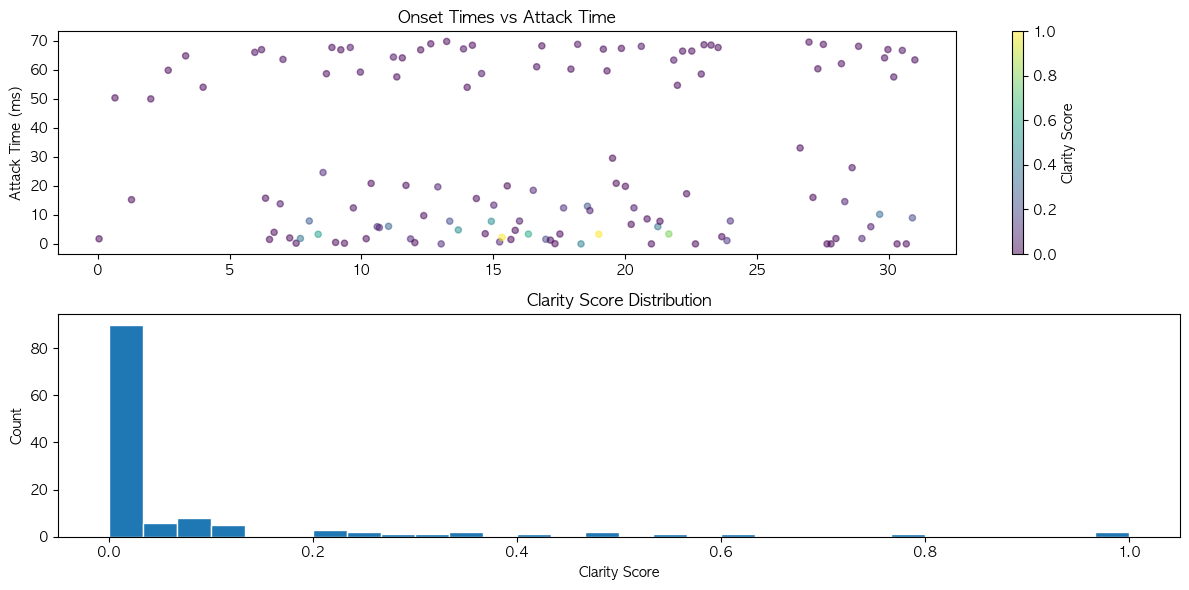

In [13]:
# 시각화
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.scatter(onset_times, attack_times, alpha=0.5, s=20, c=clarity_score, cmap='viridis')
plt.colorbar(label='Clarity Score')
plt.ylabel('Attack Time (ms)')
plt.title('Onset Times vs Attack Time')

plt.subplot(2, 1, 2)
plt.hist(clarity_score, bins=30, edgecolor='white')
plt.xlabel('Clarity Score')
plt.ylabel('Count')
plt.title('Clarity Score Distribution')

plt.tight_layout()
plt.show()

In [14]:
# JSON 내보내기
out = {
    "metadata": {
        "source": os.path.basename(audio_path),
        "sr": sr,
        "hop_length": int(hop_length),
        "bpm": round(float(bpm), 2),
        "total_events": len(onset_times)
    },
    "events": []
}

for i in range(len(onset_times)):
    out["events"].append({
        "index": i,
        "time": round(float(onset_times[i]), 4),
        "frame": int(onset_frames[i]),
        "strength": round(float(strengths[i]), 4),
        "attack_time_ms": round(float(attack_times[i]), 2),
        "clarity_score": round(float(clarity_score[i]), 4)
    })

samples_dir = os.path.join(project_root, "audio_engine", "samples")
os.makedirs(samples_dir, exist_ok=True)
json_path = os.path.join(samples_dir, "onset_events_clarity.json")

with open(json_path, "w", encoding="utf-8") as f:
    json.dump(out, f, ensure_ascii=False, indent=2)

web_public = os.path.join(project_root, "web", "public")
if os.path.isdir(web_public):
    shutil.copy(json_path, os.path.join(web_public, "onset_events_clarity.json"))
    print(f"웹 public 복사 완료: web/public/onset_events_clarity.json")

print(f"저장 완료: {json_path}")

웹 public 복사 완료: web/public/onset_events_clarity.json
저장 완료: /Users/laxogud/MADCAMP/W4/music-anaylzer/audio_engine/samples/onset_events_clarity.json
